## Catboost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

import catboost
from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import train_test_split

In [2]:
# Skip this part If you already processed data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df_train.drop('Cabin', axis = 1, inplace = True)
df_test.drop('Cabin', axis = 1, inplace = True)

df_train['Embarked'] = df_train['Embarked'].fillna(value='S')
df_test['Embarked'] = df_test['Embarked'].fillna(value='S')

# Extract title of passengers
df_train['title'] = df_train['Name'].apply(lambda x: x.split()[1])
df_test['title'] = df_test['Name'].apply(lambda x: x.split()[1])

df_train['Surname'] = df_train['Name'].apply(lambda x: x.split()[0])
df_test['Surname'] = df_test['Name'].apply(lambda x: x.split()[0])

df_test['Fare'].fillna(df_test['Fare'].mean(), inplace = True)

In [4]:
# Missing data from train dataset
print(df_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
title            0
Surname          0
dtype: int64


In [5]:
# Missing data in age column is 20 % of train data.
# so it needs a special filling process
def fill_missing_age(dataset):
    # Index of missing values:
    a = dataset['Age'].isnull()
    missing_index = a[a == True].index
    
    # Lets find the age median based on categories like: Sex and Pclass
    median = dataset.groupby(['Sex', 'Pclass']).median()
    median.reset_index(inplace = True)
    
    for i in missing_index:
        sex_pclass = dataset.iloc[i][['Sex', 'Pclass']]
        sex = sex_pclass[0]
        pclass = sex_pclass[1]
        missing_age = median[(median['Sex'] == sex) & (median['Pclass'] == pclass)]['Age'].tolist()[0]
        dataset['Age'][i] = missing_age

In [6]:
# Fill age data from both training and test datasets
fill_missing_age(df_train)
print(df_train.isnull().sum())

print('Missing data from test set before filling ------ \n', df_test.isnull().sum())

fill_missing_age(df_test)
print('Missing data from test set after filling ------ \n', df_test.isnull().sum())

C:\Users\u0125384\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
title          0
Surname        0
dtype: int64
Missing data from test set before filling ------ 
 PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
title           0
Surname         0
dtype: int64
Missing data from test set after filling ------ 
 PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
title          0
Surname        0
dtype: int64


### Data Visualization

<IPython.core.display.Javascript object>


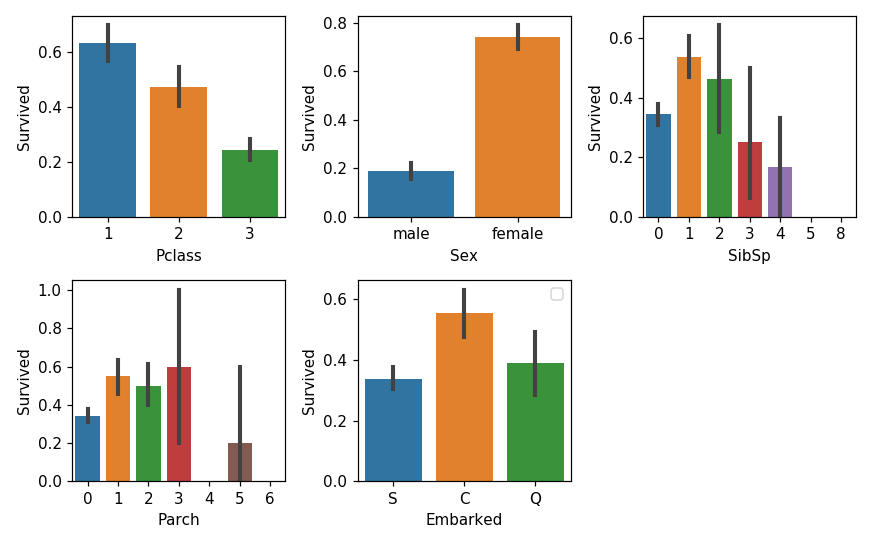

No handles with labels found to put in legend.


In [13]:
# Bar plot of survived passenger
%matplotlib notebook
plt.figure(figsize=(8, 5))
col = ['Pclass', 'Sex','SibSp', 'Parch', 'Embarked']
for i in range(5):
    plt.subplot(2, 3, i + 1)
    sns.barplot(df_train[col[i]], df_train['Survived'])                
    plt.xlabel(col[i])
plt.ylabel('Survived')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


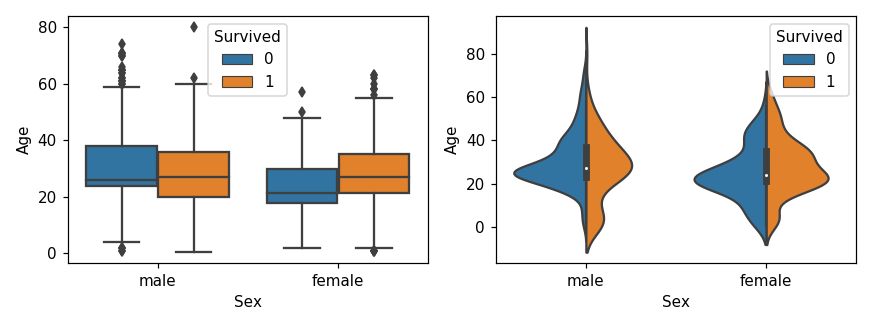

In [11]:
# Survived passenger plot based on age and sex
%matplotlib notebook
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.boxplot(x="Sex", y="Age", hue="Survived",data=df_train)
plt.subplot(1, 2, 2)
sns.violinplot(x = 'Sex', y = 'Age', hue = 'Survived', data = df_train, split = True)
plt.tight_layout()

<IPython.core.display.Javascript object>


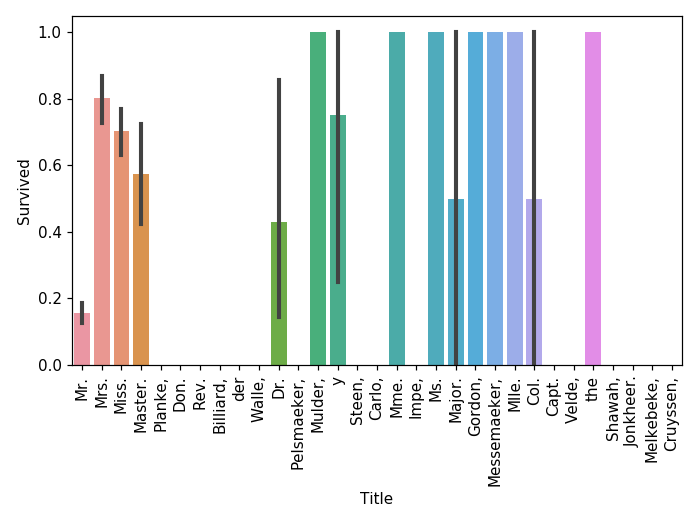

In [15]:
# Survived plot in terms of passengers' title
# Pay attention to Mr. vs Mrs., Miss
# Interesting facts: messemaker is survived, Captain is not survived
%matplotlib notebook
sns.barplot(df_train['title'], df_train['Survived'])
plt.xlabel('Title')
plt.xticks(rotation = 90)
plt.tight_layout()

<IPython.core.display.Javascript object>


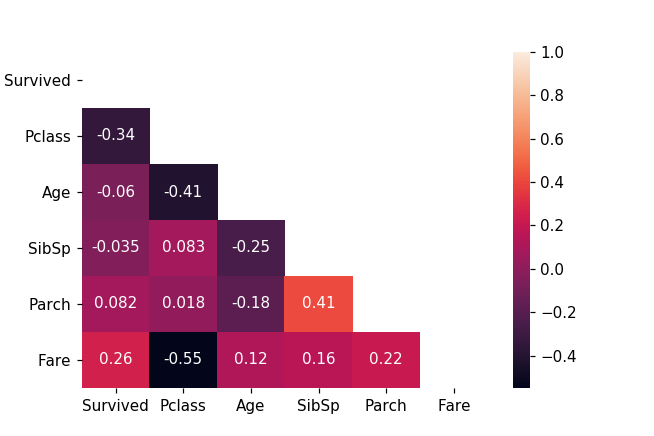

In [25]:
# Correlation between features
%matplotlib notebook
df_corr = df_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_corr, mask = mask, annot=True)

### CatBoostClassifier

In [63]:
# I only used categorical features
x = df_train[['Pclass', 'Sex','SibSp', 'Parch', 'Embarked', 'title', 'Surname']]
y = df_train.Survived

In [64]:
model = CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=42,  
                          loss_function='Logloss', custom_metric='AUC:hints=skip_train~false', metric_period=20)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 0)

In [66]:
cate_features_index = [1, 4, 5, 6]
model.fit(x, y, cat_features = cate_features_index, eval_set=(x_test,y_test))

Learning rate set to 0.030798
0:	learn: 0.8103255	test: 0.7985075	best: 0.7985075 (0)	total: 38.1ms	remaining: 38.1s
20:	learn: 0.8237935	test: 0.8059701	best: 0.8059701 (20)	total: 446ms	remaining: 20.8s
40:	learn: 0.8327722	test: 0.8134328	best: 0.8134328 (40)	total: 824ms	remaining: 19.3s
60:	learn: 0.8473625	test: 0.8582090	best: 0.8582090 (60)	total: 1.11s	remaining: 17.1s
80:	learn: 0.8540965	test: 0.8656716	best: 0.8656716 (80)	total: 1.36s	remaining: 15.5s
100:	learn: 0.8574635	test: 0.8731343	best: 0.8731343 (100)	total: 1.64s	remaining: 14.6s
120:	learn: 0.8585859	test: 0.8731343	best: 0.8731343 (100)	total: 1.98s	remaining: 14.4s
140:	learn: 0.8574635	test: 0.8731343	best: 0.8731343 (100)	total: 2.21s	remaining: 13.5s
160:	learn: 0.8574635	test: 0.8731343	best: 0.8731343 (100)	total: 2.41s	remaining: 12.5s
180:	learn: 0.8597082	test: 0.8731343	best: 0.8731343 (100)	total: 2.53s	remaining: 11.5s
200:	learn: 0.8597082	test: 0.8731343	best: 0.8731343 (100)	total: 2.73s	remainin

In [67]:
model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 42,
 'use_best_model': True,
 'metric_period': 20,
 'custom_metric': 'AUC:hints=skip_train~false',
 'eval_metric': 'Accuracy'}

In [68]:
Pool(x,y,cat_features=cate_features_index)

In [ ]:
score = []
for i in [4, 5, 6, 7, 8, 9]:
    cv_data = cv(Pool(x,y,cat_features=cate_features_index), model.get_params(),fold_count=i, plot = False)

    print('Best cv test score {:0.3f} +/- {:0.3f}'.format(cv_data['test-Accuracy-mean'].mean(), 
                                                              cv_data['test-Accuracy-std'].std()))

    print('Best cv train score {:0.3f} +/- {:0.3f}'.format(cv_data['train-Accuracy-mean'].mean(), 
                                                              cv_data['train-Accuracy-std'].std()))

    score.append([i, cv_data['test-Accuracy-mean'].mean(), cv_data['test-Accuracy-mean'].std(), 
                     cv_data['train-Accuracy-mean'].mean(), cv_data['train-Accuracy-mean'].std()])

0:	learn: 0.8069475	test: 0.7912806	best: 0.7912806 (0)	total: 209ms	remaining: 3m 28s
20:	learn: 0.8316527	test: 0.8193079	best: 0.8193079 (20)	total: 2.18s	remaining: 1m 41s
40:	learn: 0.8361386	test: 0.8282715	best: 0.8282715 (40)	total: 4.03s	remaining: 1m 34s
60:	learn: 0.8428769	test: 0.8293976	best: 0.8293976 (60)	total: 5.76s	remaining: 1m 28s
80:	learn: 0.8458675	test: 0.8327710	best: 0.8327710 (80)	total: 7.5s	remaining: 1m 25s
100:	learn: 0.8499848	test: 0.8316499	best: 0.8327710 (80)	total: 9.16s	remaining: 1m 21s
120:	learn: 0.8514791	test: 0.8338821	best: 0.8338821 (120)	total: 10.8s	remaining: 1m 18s
140:	learn: 0.8548456	test: 0.8350082	best: 0.8350082 (140)	total: 12.4s	remaining: 1m 15s
160:	learn: 0.8578380	test: 0.8338821	best: 0.8350082 (140)	total: 14s	remaining: 1m 13s
180:	learn: 0.8627055	test: 0.8372604	best: 0.8372604 (180)	total: 15.6s	remaining: 1m 10s
200:	learn: 0.8645740	test: 0.8372504	best: 0.8372604 (180)	total: 16.9s	remaining: 1m 7s
220:	learn: 0.86

800:	learn: 0.9166652	test: 0.8327832	best: 0.8372525 (560)	total: 1m 12s	remaining: 17.9s
820:	learn: 0.9183498	test: 0.8316659	best: 0.8372525 (560)	total: 1m 14s	remaining: 16.1s
840:	learn: 0.9186299	test: 0.8316596	best: 0.8372525 (560)	total: 1m 15s	remaining: 14.3s
860:	learn: 0.9191917	test: 0.8294250	best: 0.8372525 (560)	total: 1m 17s	remaining: 12.5s
880:	learn: 0.9200332	test: 0.8305423	best: 0.8372525 (560)	total: 1m 19s	remaining: 10.7s
900:	learn: 0.9214369	test: 0.8294250	best: 0.8372525 (560)	total: 1m 21s	remaining: 8.94s
920:	learn: 0.9217174	test: 0.8305423	best: 0.8372525 (560)	total: 1m 23s	remaining: 7.13s
940:	learn: 0.9225589	test: 0.8294250	best: 0.8372525 (560)	total: 1m 24s	remaining: 5.32s
960:	learn: 0.9231191	test: 0.8294250	best: 0.8372525 (560)	total: 1m 26s	remaining: 3.52s
980:	learn: 0.9239610	test: 0.8283077	best: 0.8372525 (560)	total: 1m 28s	remaining: 1.72s
999:	learn: 0.9248026	test: 0.8271904	best: 0.8372525 (560)	total: 1m 30s	remaining: 0us
B

In [70]:
# scores for different fold_count
score

[[7,
  0.8225180054523996,
  0.006295115119280511,
  0.8887063003596802,
  0.02878875763987883]]

In [71]:
# Let's use fold_count = 7
cv_data = cv(Pool(x,y,cat_features=cate_features_index), model.get_params(),fold_count=7, plot = False)

0:	learn: 0.8086309	test: 0.7958260	best: 0.7958260 (0)	total: 374ms	remaining: 6m 13s
20:	learn: 0.8280945	test: 0.8136744	best: 0.8136744 (20)	total: 3.92s	remaining: 3m 2s
40:	learn: 0.8357602	test: 0.8170490	best: 0.8170490 (40)	total: 7.04s	remaining: 2m 44s
60:	learn: 0.8411880	test: 0.8316197	best: 0.8316197 (60)	total: 9.84s	remaining: 2m 31s
80:	learn: 0.8456786	test: 0.8327358	best: 0.8327358 (80)	total: 12.6s	remaining: 2m 23s
100:	learn: 0.8479229	test: 0.8349855	best: 0.8349855 (100)	total: 15.4s	remaining: 2m 17s
120:	learn: 0.8512896	test: 0.8316109	best: 0.8349855 (100)	total: 18s	remaining: 2m 10s
140:	learn: 0.8531597	test: 0.8316197	best: 0.8349855 (100)	total: 20.6s	remaining: 2m 5s
160:	learn: 0.8559660	test: 0.8304948	best: 0.8349855 (100)	total: 23.2s	remaining: 2m
180:	learn: 0.8583963	test: 0.8304860	best: 0.8349855 (100)	total: 25.8s	remaining: 1m 56s
200:	learn: 0.8610143	test: 0.8304860	best: 0.8349855 (100)	total: 28.2s	remaining: 1m 52s
220:	learn: 0.86382

In [72]:
# Let have a look at cv data:
cv_data.head()

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std
0,0,0.795826,0.039164,0.808631,0.015485,0.675245,0.002041,0.674729,0.001431,0.841737,0.048757,0.853928,0.012523
1,20,0.813674,0.018646,0.828095,0.005322,0.500295,0.022417,0.490504,0.009217,0.857933,0.044918,0.876623,0.009311
2,40,0.817049,0.023033,0.835760,0.009010,0.448468,0.034342,0.430495,0.009751,0.856858,0.048737,0.884370,0.008979
3,60,0.831620,0.027689,0.841188,0.005992,0.420227,0.042323,0.400451,0.010554,0.869232,0.046483,0.894518,0.009864
4,80,0.832736,0.026937,0.845679,0.007844,0.409595,0.047847,0.383611,0.008609,0.868492,0.045496,0.902391,0.007863


In [77]:
print('Best cv test score {:0.3f} +/- {:0.3f}'.format(cv_data['test-Accuracy-mean'].mean(), 
                                                      cv_data['test-Accuracy-std'].std()))

print('Best cv train score {:0.3f} +/- {:0.3f}'.format(cv_data['train-Accuracy-mean'].mean(), 
                                                      cv_data['train-Accuracy-std'].std()))

Best cv test score 0.823 +/- 0.003
Best cv train score 0.889 +/- 0.002


<IPython.core.display.Javascript object>


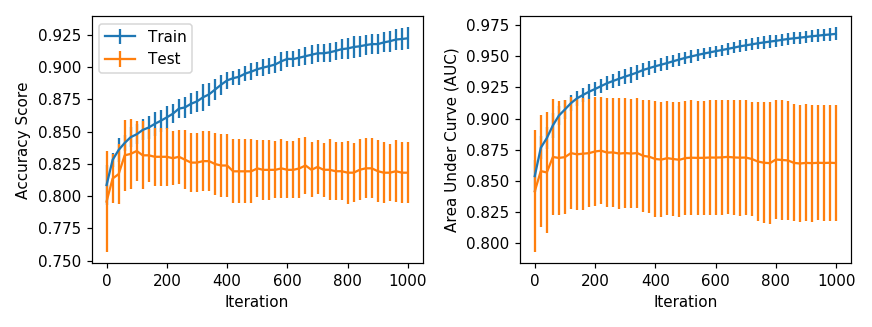

In [78]:
# To plot Accuracy score and AUC.
# Note that in cv(Pool....) you have a plot option as well
%matplotlib notebook
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.errorbar(cv_data.iterations, cv_data['train-Accuracy-mean'], yerr = cv_data['train-Accuracy-std'], label = 'Train')
plt.errorbar(cv_data.iterations, cv_data['test-Accuracy-mean'], yerr = cv_data['test-Accuracy-std'], label = 'Test')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy Score')
plt.subplot(1, 2, 2)
plt.errorbar(cv_data.iterations, cv_data['train-AUC-mean'], yerr = cv_data['train-AUC-std'], label = 'Train')
plt.errorbar(cv_data.iterations, cv_data['test-AUC-mean'], yerr = cv_data['test-AUC-std'], label = 'Test')
plt.xlabel('Iteration')
plt.ylabel('Area Under Curve (AUC)')
plt.tight_layout()

In [79]:
# Prepare the submission file
def prepare_submission(model, x, file_name):
      
    # Predict saleprice for test dataset
    y_prediction = model.predict(x)
    # Prepare submission file
    submission = pd.DataFrame({'PassengerId': df_test['PassengerId'].tolist(), 'Survived': y_prediction})
    submission.to_csv(file_name, index = False)

In [80]:
prepare_submission(model, df_test[['Pclass', 'Sex','SibSp', 'Parch', 
                                   'Embarked', 'title', 'Surname']], 'simple_catboost.csv')

